In [1]:
!pip install monai==1.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.8 MB/s eta 0:00:00


In [2]:
import os
import tempfile
import glob
import random
import numpy as np
import gc
import uuid
import pickle
import time
import re

import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.model_selection import train_test_split

from monai.utils import set_determinism, first
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import *
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, ConfusionMatrixMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data.synthetic import create_test_image_3d

import torch.nn.functional as F
import torch

2024-08-21 20:58:32.283725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 20:58:32.283840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 20:58:32.403820: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
num_labels = 3

input_shape = (4,1,128,128,128)

device='cuda:0'

In [4]:
def get_recent_checkpoint(dir_path, idx=0, ):
    paths = glob.glob(dir_path+'/*')
    
    if len(paths)==0:
        print('UUID not found')
        return None, None
    
    a = []
    for path in paths:
        data_file = path.split('/')[-1]
        epoch = re.findall(r'\d+', data_file)
        a.append(int(epoch[0]))
   
    if len(a)>0:
        recent_epoch = sorted(a, reverse=True)[idx]
    else:
        return None, None
   
    return recent_epoch, f'{dir_path}/data_{recent_epoch}.pkl'

In [5]:
idx, checkpoint_path = get_recent_checkpoint(dir_path='/kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862', idx=1)

print("No checkpoint found" if checkpoint_path == None else "Checkpoint found")
print(idx, checkpoint_path)

checkpoint_data = None

if checkpoint_path!=None:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     with open(checkpoint_path, 'rb') as fp:
#         best_checkpoint_data = pickle.load(fp)

    best_checkpoint_data = torch.load(checkpoint_path, map_location=device)
    
    config = best_checkpoint_data['config']
    
    exclude_list = ['config', 'net_state_dict', 'optimizer_state_dict']
    
    checkpoint_data = {}
    
    for i in best_checkpoint_data.keys():
        if i not in exclude_list:
            checkpoint_data[i] = best_checkpoint_data[i]

Checkpoint found
180 /kaggle/input/patch-smodel-aug-cp/6103f738-9d8a-481a-86e4-a02f5bd55862/data_180.pkl


In [6]:
print('Using device:', device)

# Loss function
loss_fn = DiceLoss(to_onehot_y=True, softmax=True)

# Model
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=config['out_channels'],
    channels=config['channels'],
    strides=config['strides'],
    num_res_units=config['depth']-1,
    norm=Norm.BATCH,
    ).to(device)
    
#optimizer
optimizer = torch.optim.Adam(model.parameters(), config['lr'])

#Load weights
model.load_state_dict(best_checkpoint_data["net_state_dict"])
optimizer.load_state_dict(best_checkpoint_data["optimizer_state_dict"])
print()

Using device: cuda



/opt/conda/lib/python3.10/site-packages/torch/profiler/profiler.py:339: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")
STAGE:2024-08-21 20:58:42 24:24 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-08-21 20:58:45 24:24 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-08-21 20:58:45 24:24 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2024-08-21 20:59:03 24:24 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-08-21 20:59:05 24:24 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-08-21 20:59:05 24:24 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


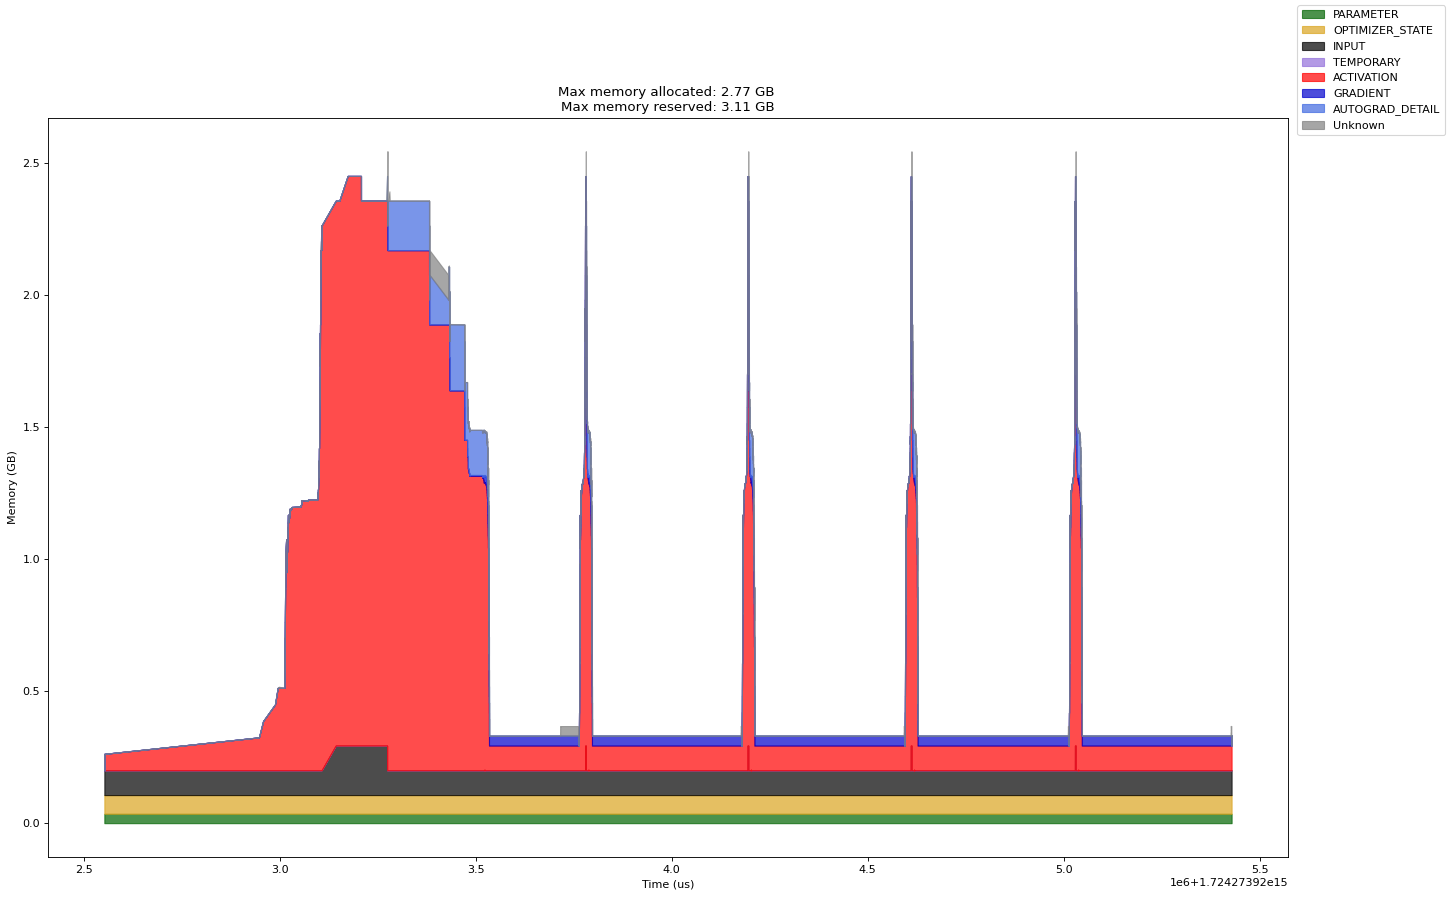

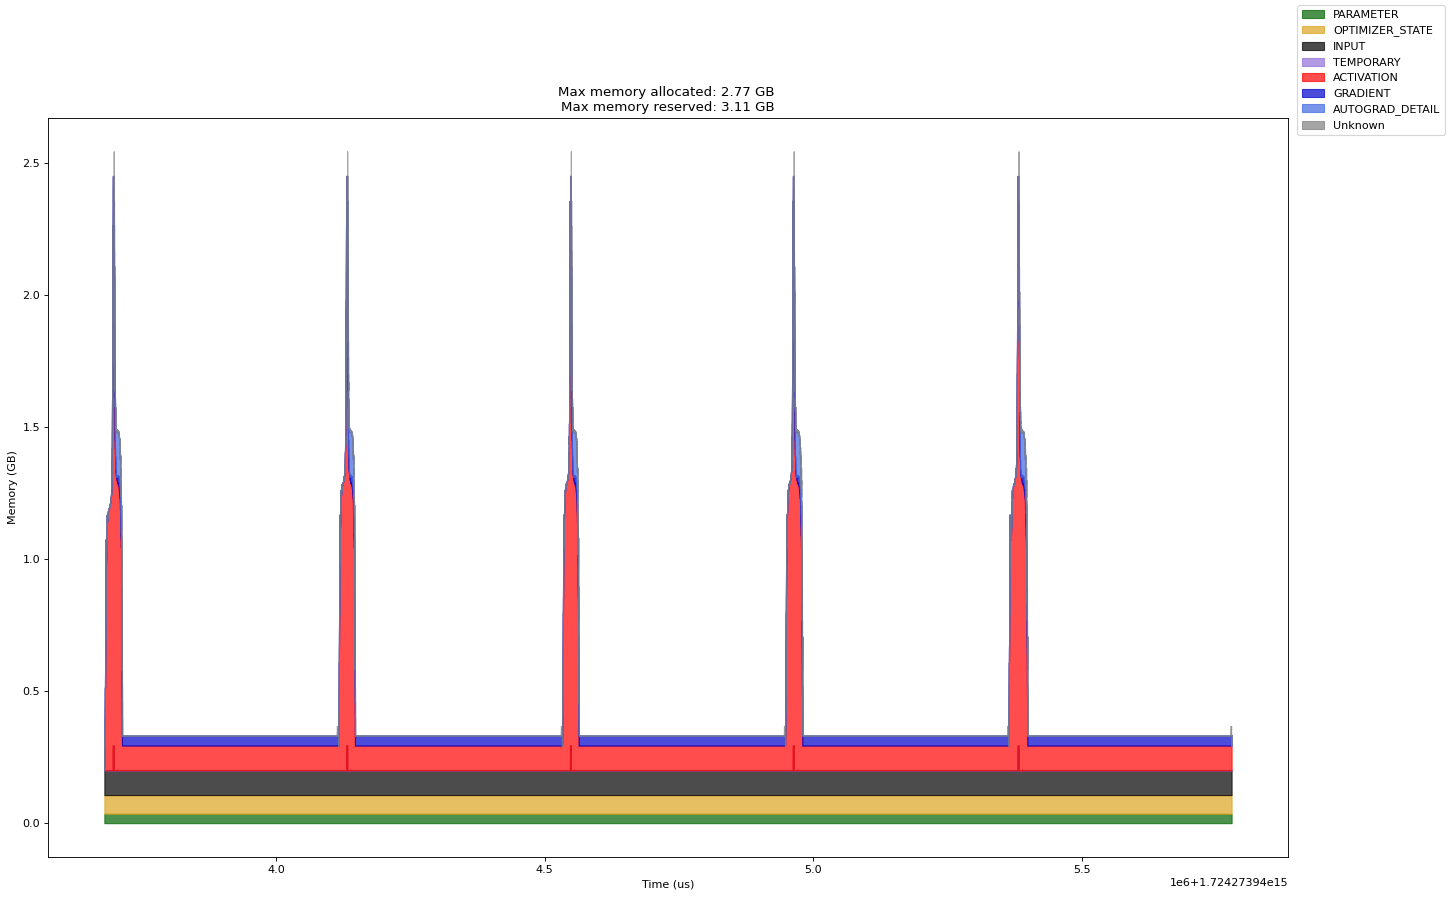

In [7]:
import logging
import socket
from datetime import datetime, timedelta

import torch

from torch.autograd.profiler import record_function
from torchvision import models

logging.basicConfig(
   format="%(levelname)s:%(asctime)s %(message)s",
   level=logging.INFO,
   datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

def trace_handler(prof: torch.profiler.profile):
   # Prefix for file names.
    host_name = socket.gethostname()
    timestamp = datetime.now().strftime(TIME_FORMAT_STR)
    file_prefix = f"{host_name}_{timestamp}"

    # Construct the trace file.
    prof.export_chrome_trace(f"{file_prefix}.json.gz")

    # Construct the memory timeline file.
    prof.export_memory_timeline(f"{file_prefix}.html", device="cuda:0")

def run(num_iters=5, device="cuda:0"):
    global model, loss_fn, optimizer
    model = model.to(device=device)
    inputs = torch.randn(size=input_shape, device=device)
    labels = torch.randint(0, 3, input_shape, device=device)

    with torch.profiler.profile(
       activities=[
           torch.profiler.ProfilerActivity.CPU,
           torch.profiler.ProfilerActivity.CUDA,
       ],
       schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
       record_shapes=True,
       profile_memory=True,
       with_stack=True,
       on_trace_ready=trace_handler,
    ) as prof:
        for _ in range(num_iters):
            prof.step()
            with record_function("## forward ##"):
                pred = model(inputs)

            with record_function("## backward ##"):
                loss_fn(pred, labels).backward() #(outputs, labels)

            with record_function("## optimizer ##"):
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)

if __name__ == "__main__":
    # Warm up
    run()
    # Run the model
    run()